<a href="https://colab.research.google.com/github/DanFON/AdaDetectGPT/blob/main/Adadelta_experiment_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing dependencies and importing libraries which are needed for data processing, visualisation and evaluation using performance metrics

In [ ]:
!pip install nest-asyncio
!pip install google.colab
!pip install opencv-python
!pip install opencv-contrib-python
import matplotlib.pyplot as chart
import seaborn as sns
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.models import model_from_json
import cv2
import os as opsys
import numpy as NUMPY
from tqdm import tqdm
from keras import backend as K
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD , Adam , Adadelta, Adagrad, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint
#from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Dropout as drop
from keras.layers import Input, Add, Dense, ZeroPadding2D,  Flatten
from keras.layers import ZeroPadding2D as ZPad
from keras.layers import Activation as non_linear_activation
from keras.layers import Conv2D as CNV_layer
from keras.layers import BatchNormalization as batch_norm
from keras.layers import MaxPooling2D as MP
from keras.layers import AveragePooling2D as AP
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from keras.regularizers import l2

In [ ]:
from PIL import Image
from IPython.display import display

Reads images from the uploaded files, checks if they are loaded and resized correctly and assigns labels, using tqdm for progress bar

In [ ]:
#def data_reading(dir, labels, img_size):
#    d = []
#    for L in labels:
#        P , class_num = opsys.path.join(dir, L), labels.index(L)
#        for I in tqdm(opsys.listdir(P)): # Added tqdm for progress bar
#            try:
#                img_path = opsys.path.join(P, I)
#                img = cv2.imread(img_path)
#                if img is not None: # Check if image loaded successfully
#                    resized_img = cv2.resize(img, (img_size, img_size))
#                    if resized_img is not None and resized_img.shape[0] > 0 and resized_img.shape[1] > 0: # Check if resize was successful and image is not empty
#                        d.append([resized_img, class_num])
#                    else:
#                        print(f"Skipping image {img_path} due to invalid resize.")
#                else:
#                    print(f"Skipping image {img_path} as it could not be loaded.")
#            except Exception as e:
#                print(f"Error processing image {img_path}: {e}")
#    return NUMPY.array(d, dtype=object)

In [ ]:
#def data_reading(dir, labels, img_size):
#    d = []
#    output_labels = []
#    for category in labels:
#        path = os.path.join(dir, category)
#        class_num = labels.index(category)
#        for img in os.listdir(path):
#            img_array = cv2.imread(os.path.join(path, img))
#            if img_array is not None:
#                img_array = cv2.resize(img_array, (img_size, img_size))
#                d.append(img_array)
#                output_labels.append(class_num)
#    return NUMPY.array(d), NUMPY.array(output_labels)

Another version of the data_reding function that has additional error handling and logging
#check if still needed

In [ ]:
def data_reading(dir, labels, img_size):
    images = []
    image_labels = []
    for L in labels:
        folder_path = opsys.path.join(dir, L)
        print(f"Searching in: {folder_path}")

        if not opsys.path.exists(folder_path):
            print(f" Folder not found: {folder_path}")
            continue

        for I in opsys.listdir(folder_path):
            try:
                img = cv2.imread(opsys.path.join(folder_path, I))
                if img is None:
                    print(f" Could not read image: {I}")
                    continue
                resized = cv2.resize(img, (img_size, img_size))
                images.append(resized)
                image_labels.append(labels.index(L))
            except Exception as e:
                print(f"Error processing {I}: {e}")

    print(f" Loaded {len(images)} items from {dir}")
    return NUMPY.array(images), NUMPY.array(image_labels)

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/chest_xray.zip'
extract_path = '/content/chest_xray'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
!ls /content/chest_xray/__chest_xray/train

NORMAL	PNEUMONIA


Displaying images with their corresponding labels

In [ ]:
def display(information):

    chart.figure(figsize = (7,7))
    chart.imshow(information[0][0], cmap='gray')
    chart.title(labels[information[0][1]])

    chart.figure(figsize = (7,7))
    chart.imshow(information[-1][0], cmap='gray')
    chart.title(labels[information[-1][1]])

Using data_reading function to load training and testing data

In [ ]:
labels , img_size = ['NORMAL' , 'PNEUMONIA'] , 224

# Modified the call to data_reading to match the updated function signature
train, train_labels = data_reading("/content/chest_xray/chest_xray/train", labels, img_size)
test, test_labels = data_reading("/content/chest_xray/chest_xray/test", labels, img_size)

Searching in: /content/chest_xray/chest_xray/train/NORMAL
Searching in: /content/chest_xray/chest_xray/train/PNEUMONIA
 Loaded 5227 items from /content/chest_xray/chest_xray/train
Searching in: /content/chest_xray/chest_xray/test/NORMAL
Searching in: /content/chest_xray/chest_xray/test/PNEUMONIA
 Loaded 624 items from /content/chest_xray/chest_xray/test


To visualise distribution of classes in datasets using seaborn and matplotlib

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt
from collections import Counter

def get_visualization(images, labels_array):
  label_map = {0: 'NORMAL', 1: 'PNEUMONIA'}
  labels = [label_map[item] for item in labels_array]

  sns.set(style="whitegrid")
  chart.figure(figsize=(10, 6))
  sns.countplot(x=labels)

  chart.title("Training Set Class Distribution", fontsize=16)
  chart.xlabel("Pneumonia, Normal")
  chart.ylabel("count", fontsize=12)
  chart.show()

In [ ]:
#counts = Counter(labels)
print(Counter(train_labels))
print(Counter(test_labels))
#should give the number of instances of each class, check why it's only 1

Counter({np.int64(1): 3881, np.int64(0): 1346})
Counter({np.int64(1): 390, np.int64(0): 234})


In [ ]:
print(labels[:30])
print(len(labels))

['NORMAL', 'PNEUMONIA']
2


In [ ]:
labels = []
path = '/content/chest_xray/chest_xray/train' # Use the correct path variable

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
        labels.append(folder)

In [ ]:
!ls /content/chest_xray/chest_xray/train/PNEUMONIA

BACTERIA-1008087-0001.jpeg  BACTERIA-5503803-0003.jpeg	VIRUS-1334718-0002.jpeg
BACTERIA-1025587-0001.jpeg  BACTERIA-5507616-0001.jpeg	VIRUS-1335423-0004.jpeg
BACTERIA-1027194-0001.jpeg  BACTERIA-5510638-0001.jpeg	VIRUS-1335423-0005.jpeg
BACTERIA-1033441-0001.jpeg  BACTERIA-5510638-0002.jpeg	VIRUS-1335423-0006.jpeg
BACTERIA-103798-0001.jpeg   BACTERIA-5510638-0003.jpeg	VIRUS-1335423-0007.jpeg
BACTERIA-103798-0002.jpeg   BACTERIA-5510638-0004.jpeg	VIRUS-1335423-0008.jpeg
BACTERIA-1039608-0001.jpeg  BACTERIA-5510638-0005.jpeg	VIRUS-1335423-0009.jpeg
BACTERIA-1040986-0001.jpeg  BACTERIA-5510638-0006.jpeg	VIRUS-1335423-0010.jpeg
BACTERIA-1041881-0001.jpeg  BACTERIA-5510638-0007.jpeg	VIRUS-1335423-0011.jpeg
BACTERIA-1041881-0002.jpeg  BACTERIA-5510638-0008.jpeg	VIRUS-134339-0002.jpeg
BACTERIA-104960-0001.jpeg   BACTERIA-5510638-0009.jpeg	VIRUS-1355733-0002.jpeg
BACTERIA-1065620-0001.jpeg  BACTERIA-5510638-0010.jpeg	VIRUS-1356901-0002.jpeg
BACTERIA-1065620-0002.jpeg  BACTERIA-5510638-0011.jpe

In [ ]:
!find /content/chest_xray -type f | grep .jpeg | head -10

/content/chest_xray/__chest_xray/train/PNEUMONIA/BACTERIA-6500745-0004.jpeg_Error.txt
/content/chest_xray/__chest_xray/train/PNEUMONIA/BACTERIA-6489593-0001.jpeg_Error.txt
/content/chest_xray/__chest_xray/train/NORMAL/NORMAL-7707520-0001.jpeg_Error.txt
/content/chest_xray/__chest_xray/train/NORMAL/NORMAL-770087-0001.jpeg_Error.txt
/content/chest_xray/__chest_xray/train/NORMAL/NORMAL-831813-0002.jpeg_Error.txt
/content/chest_xray/chest_xray/test/PNEUMONIA/BACTERIA-518323-0001.jpeg
/content/chest_xray/chest_xray/test/PNEUMONIA/BACTERIA-2034017-0006.jpeg
/content/chest_xray/chest_xray/test/PNEUMONIA/VIRUS-258000-0001.jpeg
/content/chest_xray/chest_xray/test/PNEUMONIA/BACTERIA-3865791-0005.jpeg
/content/chest_xray/chest_xray/test/PNEUMONIA/BACTERIA-7098043-0001.jpeg


In [ ]:
zip_path = '/content/drive/MyDrive/lung_disease_undersampling.zip'
extract_path = '/content/lung_disease_undersampling'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

attempt only using one validation dataset

In [ ]:
#zip_path = '/content/drive/MyDrive/lung_disease_undersampling_.zip'
#extract_path = '/content/lung_disease_undersampling_'

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#  zip_ref.extractall(extract_path)

In [ ]:
!find /content/lung_disease_undersampling -type f | grep .jpeg | head -10

/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-9044719-0003.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/VIRUS-7611162-0001.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/VIRUS-2402649-0001.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-4531690-0004.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-9988673-0002.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/VIRUS-6212628-0001.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/VIRUS-3874052-0003.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-2977655-0001.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-987036-0001.jpeg
/content/lung_disease_undersampling/lung_disease_undersampling/PNEUMONIA/BACTERIA-3044214-0001.jpeg


In [ ]:
#!find /content/lung_disease_undersampling_ -type f | grep .jpeg | head -10

In [ ]:
print(opsys.listdir('/content/lung_disease_undersampling'))
#print(opsys.listdir('/content/lung_disease_undersampling_'))

['lung_disease_undersampling']


In [ ]:
#from inspect import classify_class_attrs
#import re, shutil

#def clean_copy(src_root, dst_root):
 #   opsys.makedirs(opsys.path.join(dst_root, 'NORMAL'), exist_ok=True)
  #  opsys.makedirs(opsys.path.join(dst_root, 'PNEUMONIA'), exist_ok=True)

   # patt_norm = re.compile(r'NORMAL', re.I)
    #patt_pneu = re.compile(r'(BACTERIA|VIRUS|PNEUMONIA)', re.I)

    #copied = 0
    #flagged = []

    #for cls in ['NORMAL', 'PNEUMONIA']:
     #   src_cls = opsys.path.join(src_root, cls)
      #  if not opsys.path.isdir(src_cls):
#            print("Missing:", src_cls); continue

       # for f in opsys.listdir(src_cls):
        #    src = opsys.path.join(src_cls, f)
         #   if not opsys.path.isfile(src):
              #  continue
          #  name = f.lower()

           # if patt_norm.search(name) and not patt_pneu.search(name):
               # label = 'NORMAL'
            #elif patt_pneu.search(name) and not patt_norm.search(name):
                #label = 'PNEUMONIA'
            #else:
             #   label = cls
              #  flagged.append((cls, f))

          #  dst = opsys.path.join(dst_root, label, f)
           # shutil.copy2(src,dst)
            #copied += 1

    #print(f"Copied {copied} files into {dst_root}. Ambiguous files: {len(flagged)}")
    #return flagged

#flags1 = clean_copy('/content/lung_disease_undersampling/lung_disease_undersampling', '/content/lung_disease_val_clean')
#flags2 = clean_copy('/content/lung_disease_undersampling_/lung_disease_undersampling', '/content/lung_disease_val2_clean')

COME BACK TO

In [ ]:
import tensorflow as tf

val_dataset = tf.keras.utils.image_dataset_from_directory(
    "lung_disease_undersampling/lung_disease_undersampling",
    labels="inferred",
    label_mode="binary",
    image_size=(224, 224),
    batch_size=32
)

#val_ds2 = tf.keras.utils.image_dataset_from_directory(
#    "lung_disease_undersampling_/lung_disease_undersampling_",
#    labels="inferred",
#    label_mode="binary",
#    image_size=(224, 224),
#    batch_size=32
#)

#val_images, val_labels = data_reading('/content/lung_disease_undersampling/lung_disease_undersampling', labels, img_size)
#val2_images, val2_labels = data_reading('/content/lung_disease_undersampling_/lung_disease_undersampling', labels, img_size)
#test_images, test_labels = data_reading('/content/lung_disease_undersampling_/lung_disease_undersampling/test', labels, img_size)

Found 1350 files belonging to 2 classes.


In [ ]:
for images, labels in val_dataset.take(1):
    print(labels.numpy())

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [ ]:
for i in range(5):
  print(train[i][1])

[[  3   3   3]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [ 16  16  16]
 [ 39  39  39]
 [ 42  42  42]
 [ 47  47  47]
 [ 48  48  48]
 [ 49  49  49]
 [ 57  57  57]
 [ 59  59  59]
 [ 65  65  65]
 [ 70  70  70]
 [ 76  76  76]
 [ 79  79  79]
 [ 80  80  80]
 [ 83  83  83]
 [ 83  83  83]
 [ 85  85  85]
 [ 84  84  84]
 [ 87  87  87]
 [ 84  84  84]
 [ 84  84  84]
 [ 85  85  85]
 [ 90  90  90]
 [ 90  90  90]
 [111 111 111]
 [149 149 149]
 [123 123 123]
 [122 122 122]
 [121 121 121]
 [116 116 116]
 [121 121 121]
 [112 112 112]
 [117 117 117]
 [125 125 125]
 [128 128 128]
 [129 129 129]
 [128 128 128]
 [120 120 120]
 [124 124 124]
 [105 105 105]
 [105 105 105]
 [100 100 100]
 [105 105 105]
 [102 102 102]
 [104 104 104]
 [100 100 100]
 [ 98  98  98]
 [ 93  93  93]
 [ 90  90  90]
 [104 104 104]
 [136 136 136]
 [148 148 148]
 [144 144 144]
 [150 150 150]
 [154 154 154]
 [157 157 157]
 [173 173 173]
 [189 189 189]
 [205 205 

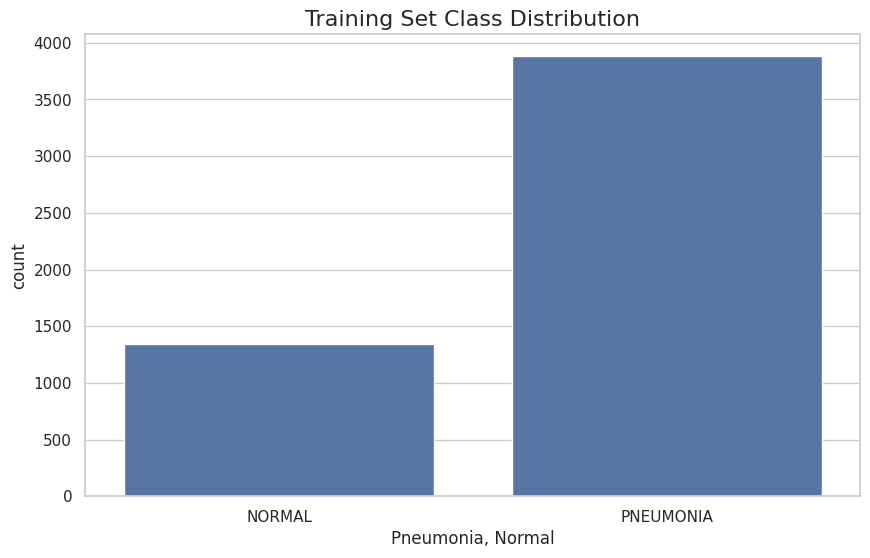

In [ ]:
get_visualization(train, train_labels)

Imbalanced dataset so model may have more false positives, should use class weights and install imbalanced-learn library to handle the class imbalance

In [ ]:
#!pip install -U imbalanced-learn

In [ ]:
#df = pd.read_csv
#print(df['label'].value_counts())

In [ ]:
train_path = '/content/chest_xray/chest_xray/train'
#val_combined = val_ds.concatenate(val_ds2)
#val_path = '/content/dataset/val'

In [ ]:
print("Size of training data",len(train))
print("Size of testing data",len(test))
print("Size of validation data", len(val_dataset))

Size of training data 5227
Size of testing data 624
Size of validation data 43


In [ ]:
print("Training images:", len(train))
print("Testing images:", len(test))
print("Validation images", len(val_dataset))

Training images: 5227
Testing images: 624
Validation images 43


COME BACK TO

In [ ]:
def display_one_normal_and_one_pneumonia(information, labels):
    normal_img, pneumonia_img = None, None

    for img, label in information:
        # Corrected the comparison to use the integer label to access the class name
        if labels[label] == "NORMAL" and normal_img is None:
            normal_img = (img, label)
        elif labels[label] == "PNEUMONIA" and pneumonia_img is None:
            pneumonia_img = (img, label)
        if normal_img and pneumonia_img:
          break

In [ ]:
#display(information)

In [ ]:
#pairs = list(zip(train, train_labels))
#display_one_normal_and_one_pneumonia(pairs, labels)

In [ ]:
def add_variable_guassian_noise(img, mean=0, sigma_range=(0.01, 0.05)):
  row, col, ch = img.shape

  sigma = NUMPY.random.uniform(sigma_range[0], sigma_range[1])
  #sigma = 0.01
  #sigma = 0.05

  gauss = NUMPY.random.normal(mean, sigma, (row, col, ch))
  noisy = img + gauss
  noisy = NUMPY.clip(noisy, 0., 1.)
  return noisy

In [ ]:
def apply_clahe(img):

    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    if img.ndim == 3 and img.shape[-1] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)

    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    img_clahe = img_clahe.astype(np.float32) / 255
    return img_clahe

In [ ]:
def preprocessing_pipeline(img, training=False):
    img = apply_clahe(img)
    if training:
        img = add_variable_guassian_noise(img)

    return img

Data augmentation by applying transformations to training data to increase diversity of training dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocessing_pipeline(x, training=True),
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    #shear_range=0.2,
    brightness_range=(0.9,1.1),
    fill_mode='nearest',
    validation_split=0.2
)

val_test_datagen = ImageDataGenerator(preprocessing_function=lambda x: preprocessing_pipeline(x, training=False))

In [ ]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
val_generator = val_test_datagen.flow_from_directory("lung_disease_undersampling/lung_disease_undersampling",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')
#val2_generator = val_datagen.flow_from_directory("lung_disease_undersampling_/lung_disease_undersampling", target_size=(224,224), batch_size=32, shuffle=False,class_mode='binary')
test_generator = val_test_datagen.flow_from_directory("chest_xray/chest_xray/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 5227 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
#import numpy as np
#from sklearn.utils.class_weight import compute_class_weight

#y_train = [item[1] for item in train] # This line is not needed with the current data structure
#X = NUMPY.array([item[0] for item in train]) # This line is not needed with the current data structure
#y = NUMPY.array([item[1] for item in train]) # This line is not needed with the current data structure

# Use the existing train_images and train_labels variables
#X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

# Normalization should be done after splitting
#X_train = X_train / 255.0
#X_test = X_test / 255.0

labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=NUMPY.unique(labels), y=labels)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# The model fitting should be done using the data generators instead of the split arrays.
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=32,
#     class_weight=class_weights
# )

Class weights: {0: np.float64(1.9416790490341753), 1: np.float64(0.673408915228034)}


In [ ]:
from collections import Counter
import numpy as np

class_counts = Counter(train_generator.classes)
print("Class distribution in training set:", class_counts)

Class distribution in training set: Counter({np.int32(1): 3881, np.int32(0): 1346})


**ResNet 50 Implementation**

Identify block to add skip connections (helps with gradient flow)

In [ ]:
def IB(L, f, filters, stage, block):

    Filter1, Filter2, Filter3 = filters

    L_shortcut = L

    L = CNV_layer(filters=Filter1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2a', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2a')(L)
    L = ReLU()(L)

    L = CNV_layer(filters=Filter2, kernel_size=(f, f), strides=(1, 1), padding='same', name='res' + str(stage) + block + '_branch' + '2b', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2b')(L)
    L = ReLU()(L)

    L = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2c', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2c')(L)

    L = Add()([L, L_shortcut])# SKIP Connection
    L = ReLU()(L)

    return L

Adding convolution layers (convolutional block) with downsampling

In [ ]:
def CB(L, f, filters, stage, block, s=2):


    Filter1, Filter2, Filter3 = filters

    L_shortcut = L

    L = CNV_layer(filters=Filter1, kernel_size=(1, 1), strides=(s, s), padding='valid', name='res' + str(stage) + block + '_branch' + '2a', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2a')(L)
    L = ReLU()(L)

    L = CNV_layer(filters=Filter2, kernel_size=(f, f), strides=(1, 1), padding='same', name='res' + str(stage) + block + '_branch' + '2b', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2b')(L)
    LookupError = ReLU()(L)

    L = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2c', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2c')(L)

    L_shortcut = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(s, s), padding='valid', name='res' + str(stage) + block + '_branch' + '1', kernel_initializer=glorot_uniform(seed=0))(L_shortcut)
    L_shortcut = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '1')(L_shortcut)

    L = Add()([L, L_shortcut])
    L = ReLU()(L)

    return L

Defining the model by combining IB and CB block to create the ResNet50 architecture

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    L_input = Input(input_shape)

    L = ZPad((3, 3))(L_input)

    L = CNV_layer(64, kernel_size=(7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn_conv1')(L)
    L = ReLU()(L)
    L = MP(pool_size=(3, 3), strides=(2, 2))(L)

    L = CB(L, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    L = IB(L, 3, [64, 64, 256], stage=2, block='b')
    L = IB(L, 3, [64, 64, 256], stage=2, block='c')


    L = CB(L, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    L = IB(L, 3, [128, 128, 512], stage=3, block='b')
    #X = IB(X, 3, [128, 128, 512], stage=3, block='c')
    L = IB(L, 3, [128, 128, 512], stage=3, block='d')

    L = CB(L, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    L = IB(L, 3, [256, 256, 1024], stage=4, block='b')
    L = IB(L, 3, [256, 256, 1024], stage=4, block='c')
    #X = IB(X, 3, [256, 256, 1024], stage=4, block='d')
    #X = IB(X, 3, [256, 256, 1024], stage=4, block='e')
    L = IB(L, 3, [256, 256, 1024], stage=4, block='f')

    L = CB(L, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    L = IB(L, 3, [512, 512, 2048], stage=5, block='b')
    #X = IB(X, 3, [512, 512, 2048], stage=5, block='c')

    L = AP(pool_size=(2, 2), padding='same')(L)

    model = Model(inputs=L_input, outputs=L, name='ResNet50')

    return model

In [ ]:
adapt = ResNet50(input_shape=(224, 224, 3))

In [ ]:
adapt_design = adapt.output
adapt_design = Flatten()(adapt_design)
adapt_design = Dense(256, name='fc1',kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=l2(0.01))(adapt_design)
adapt_design = batch_norm()(adapt_design)
adapt_design = ReLU()(adapt_design)
adapt_design = drop(rate = 0.5)(adapt_design)
adapt_design = Dense(128, name='fc2',kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=l2(0.01))(adapt_design)
adapt_design = batch_norm()(adapt_design)
adapt_design = ReLU()(adapt_design)
adapt_design = drop(rate = 0.5)(adapt_design)
output = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(adapt_design)

In [ ]:
Adapt = Model(inputs=adapt.input, outputs=output)

In [ ]:
print(type(Adapt))
Adapt.summary()

<class 'keras.src.models.functional.Functional'>


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 112, 112,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_76 (ReLU)     │ (None, 112, 112,  │          0 │ bn_conv1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 55, 55,    │          0 │ re_lu_76[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 55, 55,    │      4,160 │ max_pooling2d_2[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 55, 55,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_77 (ReLU)     │ (None, 55, 55,    │          0 │ bn2a_branch2a[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 55, 55,    │     36,928 │ re_lu_77[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 55, 55,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 55, 55,    │     16,640 │ bn2a_branch2b[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 55, 55,    │     16,640 │ max_pooling2d_2[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 55, 55,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 55, 55,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ bn2a_branch2c[0]… │
│                     │ 256)              │            │ bn2a_branch1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_79 (ReLU)     │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 25,013,377 (95.42 MB)

 Trainable params: 24,973,313 (95.27 MB)

 Non-trainable params: 40,064 (156.50 KB)

visualkeras installed to visualise neural network architectures

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
# visualkeras.layered_view(Adapt, to_file='adapt_visual.png').show()

from tensorflow.keras.utils import plot_model
#plot_model(Adapt, show_shapes=True, to_file='adapt_visual.png', expand_nested=True)

In [ ]:
#from IPython.display import Image
#Image(filename='adapt_visual.png')

In [ ]:
Adapt.save("adapt_model.h5")

In [ ]:
# System-level installs (Graphviz binary and dependencies)
!apt-get -qq install -y graphviz

# Python packages
!pip install -q graphviz pydot pydotplus visualkeras netron

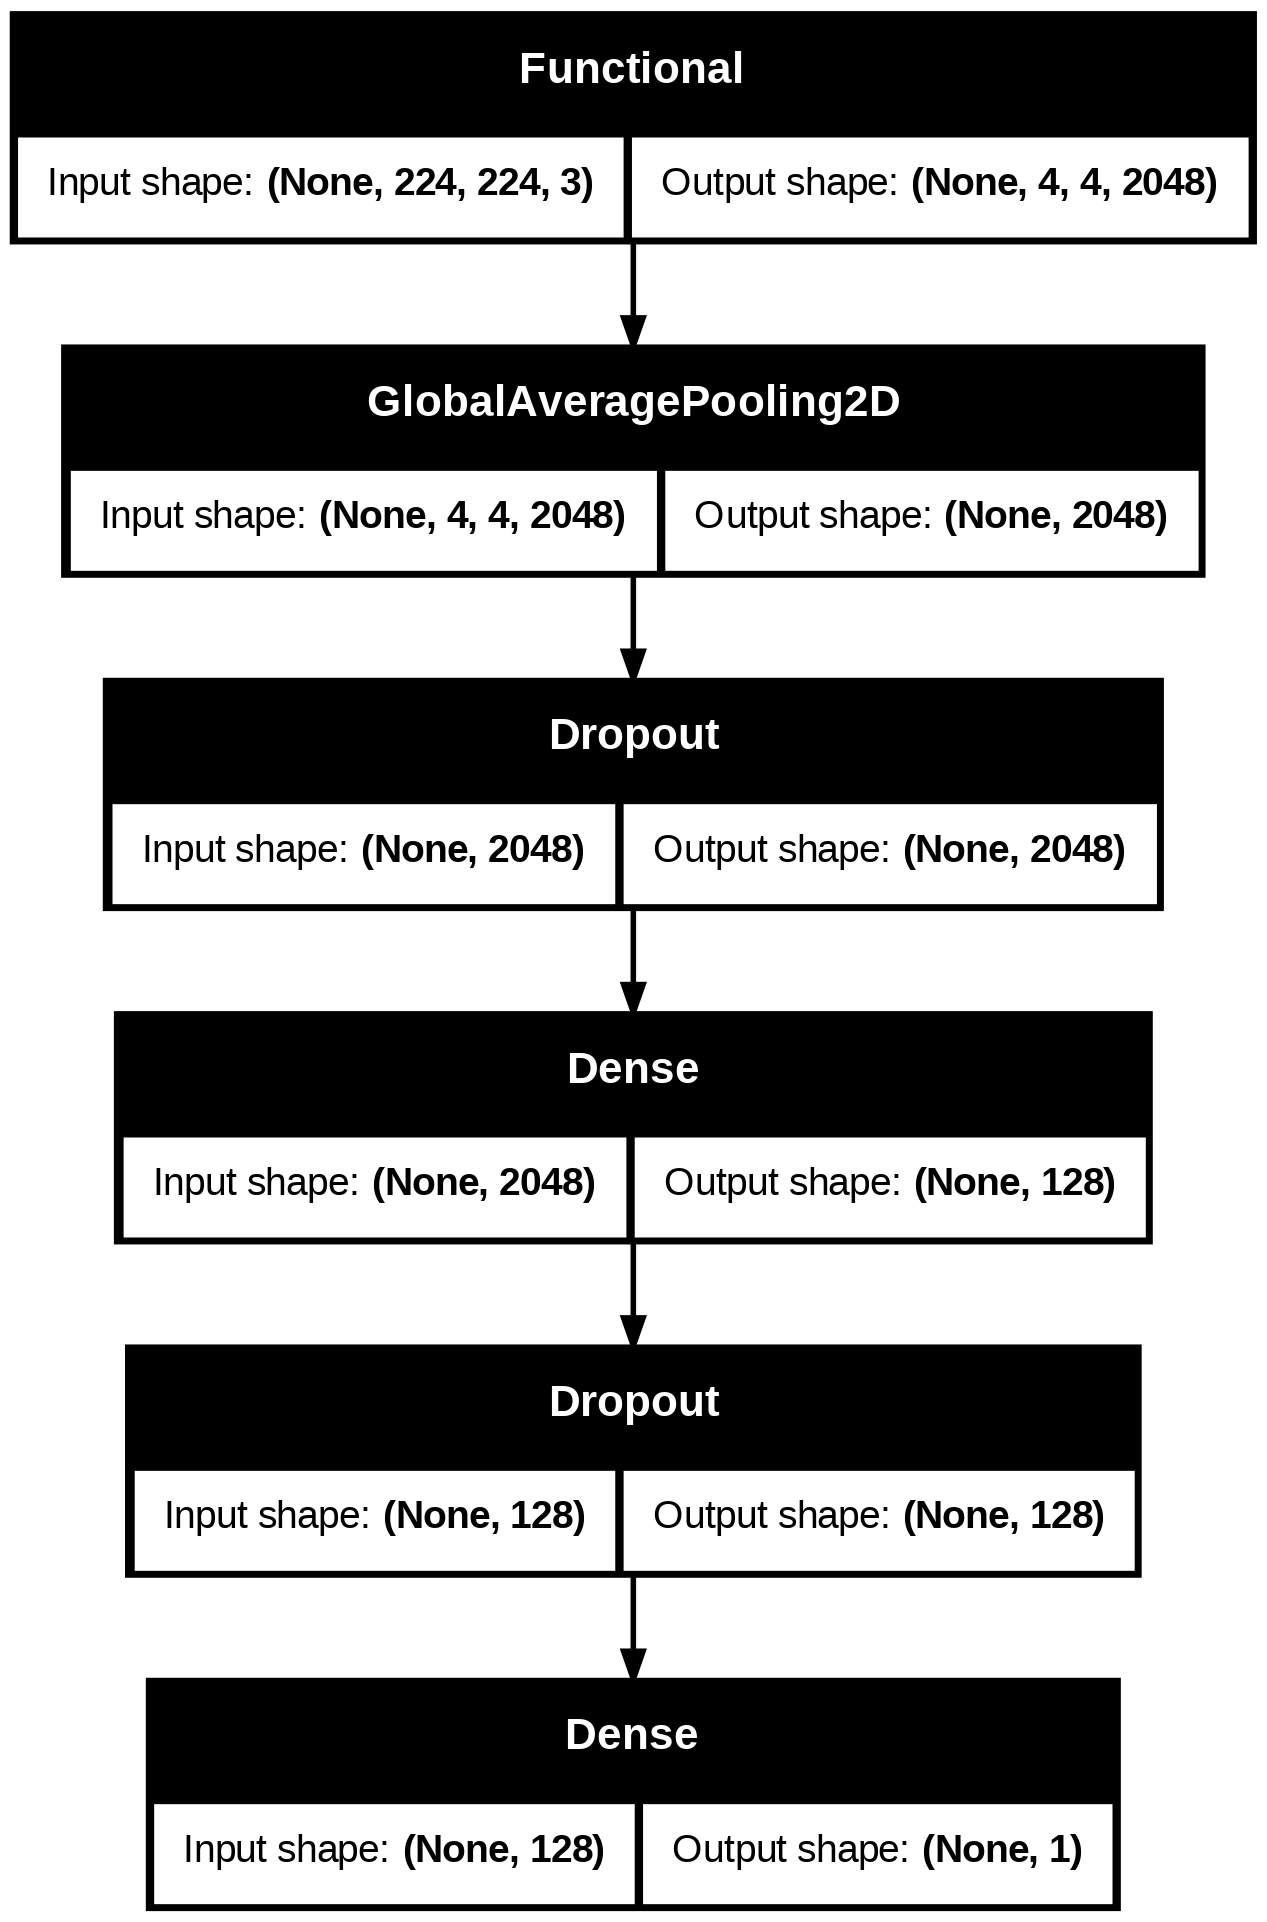

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

base_model = ResNet50(input_shape=(224, 224, 3))

for layer in Adapt.layers[:100]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
#    Dense(8, input_shape=(4,), activation='relu'),
#    Dense(3, activation='softmax')
])
plot_model(model, show_shapes=True)

In [ ]:
!pip install netron

In [ ]:
Adapt.save("adapt_model.h5")

In [ ]:
import netron
netron.start("adapt_model.h5")

('localhost', 23807)

In [ ]:
from google.colab import files
files.download('adapt_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!sudo apt-get update
!sudo apt-get install graphviz

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Ign:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Ign:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ign:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu ja

In [ ]:
#!dot -V

In [ ]:
#from tensorflow.keras import Model

# Example: Visualize only the first few layers
#submodel = Model(inputs=Adapt.input, outputs=Adapt.layers[5].output)
#visualkeras.layered_view(submodel, to_file='submodel.png').show()

In [ ]:
pip install --upgrade visualkeras

In [ ]:
#import visualkeras
#visualkeras.layered_view(Adapt, to_file='adapt_visual.png').show()

In [ ]:
Adapt.save("adapt_model.keras")

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)
checkpoint = ModelCheckpoint("model.h5",monitor='val_accuracy',save_best_only=True,mode="auto",verbose=1)

In [ ]:
#mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max')
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max')

In [ ]:
Adapt.compile(
    optimizer=Adadelta(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# epochs was previosuly 50.
H = Adapt.fit(train_generator,validation_data=val_generator,epochs=20,verbose=1,callbacks=[learning_rate_reduction,checkpoint,early_stop], class_weight=class_weights)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4674 - loss: 7.6738
Epoch 1: val_accuracy improved from -inf to 0.26074, saving model to model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 170s 922ms/step - accuracy: 0.4674 - loss: 7.6737 - val_accuracy: 0.2607 - val_loss: 7.8763 - learning_rate: 1.0000e-04
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.4846 - loss: 7.6443
Epoch 2: val_accuracy improved from 0.26074 to 0.31185, saving model to model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 849ms/step - accuracy: 0.4846 - loss: 7.6443 - val_accuracy: 0.3119 - val_loss: 7.5881 - learning_rate: 1.0000e-04
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.4804 - loss: 7.6226
Epoch 3: val_accuracy improved from 0.31185 to 0.66889, saving model to model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 137s 834ms/step - accuracy: 0.4804 - loss: 7.6225 - val_accuracy: 0.6689 - val_loss: 7.4078 - learning_rate: 1.0000e-04
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.5020 - loss: 7.6104
Epoch 4: val_accuracy did not improve from 0.66889
164/164 ━━━━━━━━━━━━━━━━━━━━ 136s 829ms/step - accuracy: 0.5020 - loss: 7.6104 - val_accuracy: 0.6252 - val_loss: 7.4476 - learning_rate: 1.0000e-04
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.4963 - loss: 7.5761
Epoch 5: val_accuracy did not improve from 0.66889
164/164 ━━━━━━━━━━━━━━━━━━━━ 138s 841ms/step - accuracy: 0.4964 - loss: 7.5761 - val_accuracy: 0.6030 - val_loss: 7.4598 - learning_rate: 1.0000e-04
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.5210 - loss: 7.5707
Epoch 6: val_accuracy did not improve from 0.66889
164/164 ━━━━━━━━━━━━━━━━━━━━ 138s 839ms/step - accuracy: 0.5210 - loss: 7.5708 - val_accuracy: 0.6178 - val_loss: 7.4525 - learning_rate

In [ ]:
def get_history_plots(epochs,Q):
    # epochs = [R for R in range(epochs)]
    fig , X = chart.subplots(1,2)
    fig.set_size_inches(15,10)

    X[0].plot([R for R in range(epochs)] , Q.history['accuracy'] ,'g' , label = 'Training Accuracy')
    X[0].plot([R for R in range(epochs)] , Q.history['val_accuracy'] ,'r', label = 'Validation Accuracy')
    X[0].set_title('Training & Validation Accuracy')
    X[0].legend()
    X[0].set_xlabel("Epochs")
    X[0].set_ylabel("Accuracy")

    X[1].plot([R for R in range(epochs)] , Q.history['loss'] , 'g' , label = 'Training Loss')
    X[1].plot([R for R in range(epochs)] , Q.history['val_loss'] , 'r' , label = 'Validation Loss')
    X[1].set_title('Training Accuracy & Loss')
    X[1].legend()
    X[1].set_xlabel("Epochs")
    X[1].set_ylabel("Training & Validation Loss")
    chart.show()

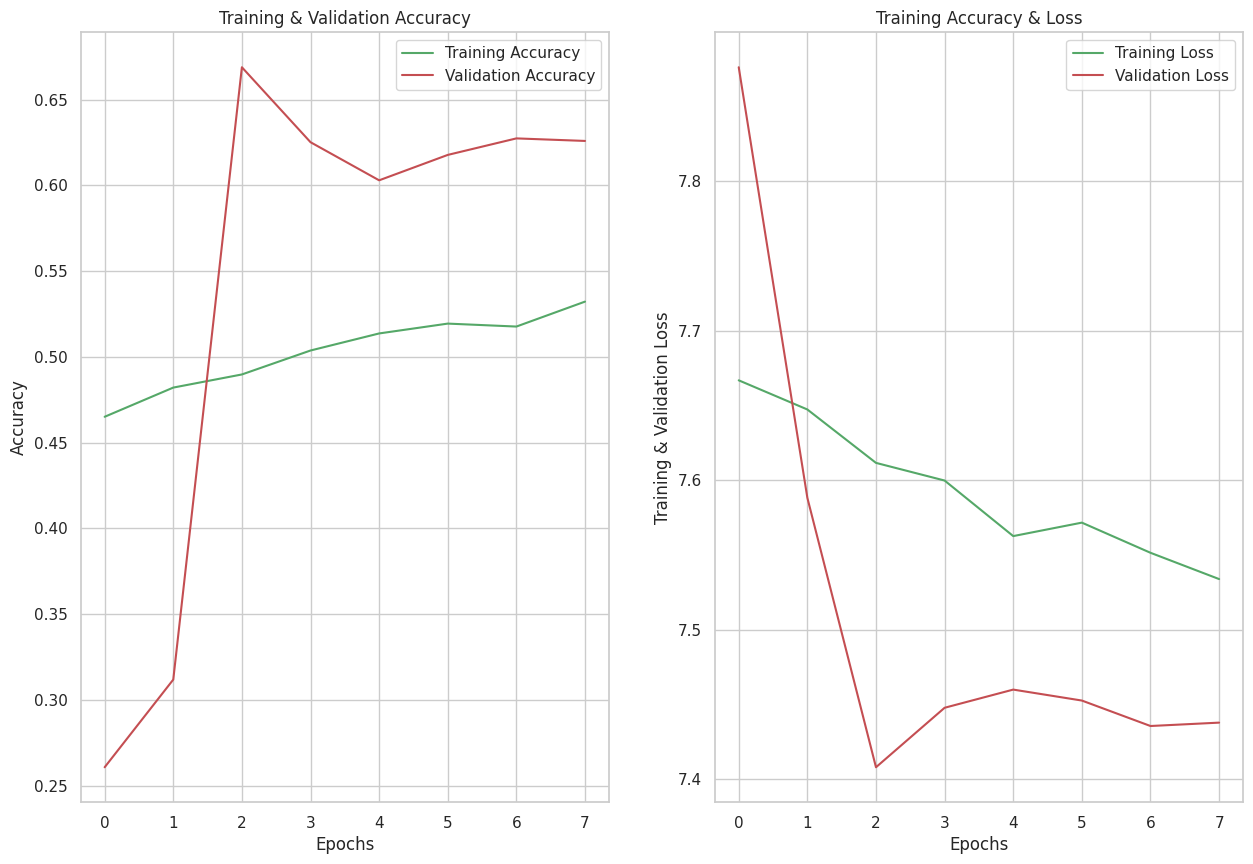

In [ ]:
get_history_plots(8,H)

In [ ]:
#Adapt.evaluate(val_dataset)

In [ ]:
results = Adapt.evaluate(test_generator, steps=len(test_generator))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.5943 - loss: 7.4460


In [ ]:
Y_pred = Adapt.predict(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 409ms/step


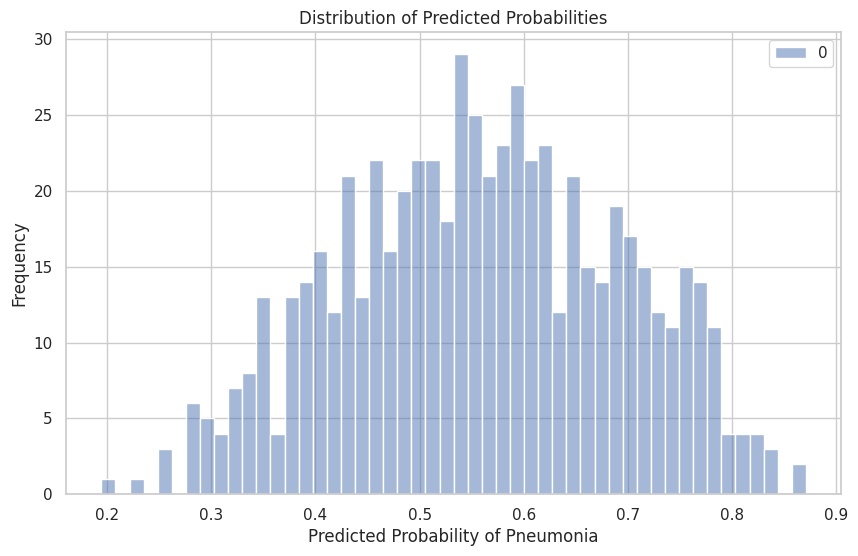

In [ ]:
chart.figure(figsize=(10,6))
sns.histplot(Y_pred, bins=50, color='blue')
chart.title('Distribution of Predicted Probabilities')
chart.xlabel('Predicted Probability of Pneumonia')
chart.ylabel('Frequency')
chart.grid(True)
chart.show()

In [ ]:
#P = []
#for Y in range(0,len(Y_pred)):
  #if Y_pred[Y][0] >= 0.5:
    #P.append(1)
  #else:
    #P.append(0)

In [ ]:
optimal_threshold = 0.5
P = [] # Initialize P as an empty list
for Y in range(0, len(Y_pred)):
  if Y_pred[Y][0] >= optimal_threshold:
    P.append(1)
  else:
    P.append(0)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step
AUC_ROC Score: 0.7145737453429761
Optimal Threshold from ROC Analysis: 0.5765187740325928


<function matplotlib.pyplot.show(close=None, block=None)>

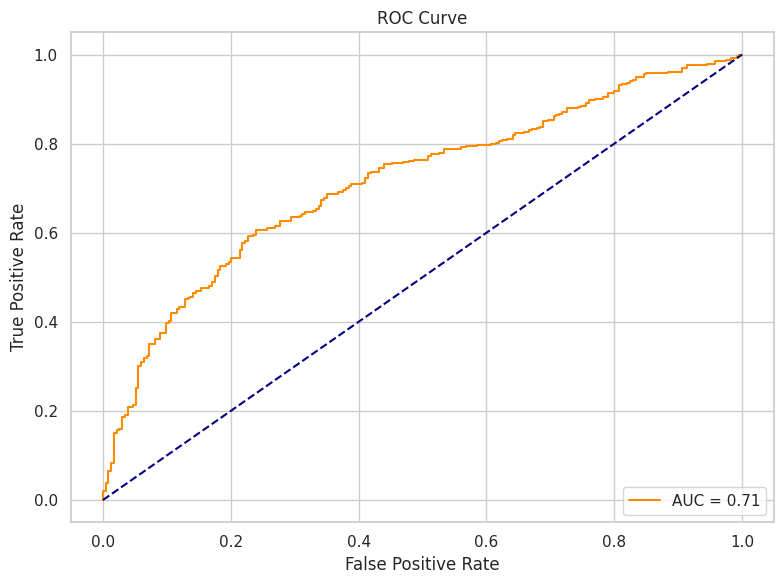

In [ ]:
y_true = test_generator.classes
predictions = Adapt.predict(test_generator)

auc_score = roc_auc_score(y_true, predictions)
print("AUC_ROC Score:", auc_score)

fpr, tpr, thresholds = roc_curve(y_true, predictions)

J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from ROC Analysis: {optimal_threshold}")

chart.figure(figsize=(8,6))
chart.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.2f}')
chart.plot([0, 1], [0, 1], color='navy', linestyle='--')
chart.xlabel('False Positive Rate')
chart.ylabel('True Positive Rate')
chart.title('ROC Curve')
chart.legend(loc='lower right')
chart.grid(True)
chart.tight_layout()
chart.show

In [ ]:
J = tpr -fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

In [ ]:
# Get true labels from the test generator
y_true = test_generator.classes

# Get predictions from the model using the test generator
predictions = Adapt.predict(test_generator)

# Use the optimal threshold to get predicted classes
y_pred_classes = (predictions > optimal_threshold).astype(np.int32) # Use np.int32 for consistency with Counter output

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step


Classification Report
              precision    recall  f1-score   support

      NORMAL       0.53      0.77      0.63       234
   PNEUMONIA       0.81      0.59      0.68       390

    accuracy                           0.66       624
   macro avg       0.67      0.68      0.66       624
weighted avg       0.71      0.66      0.66       624



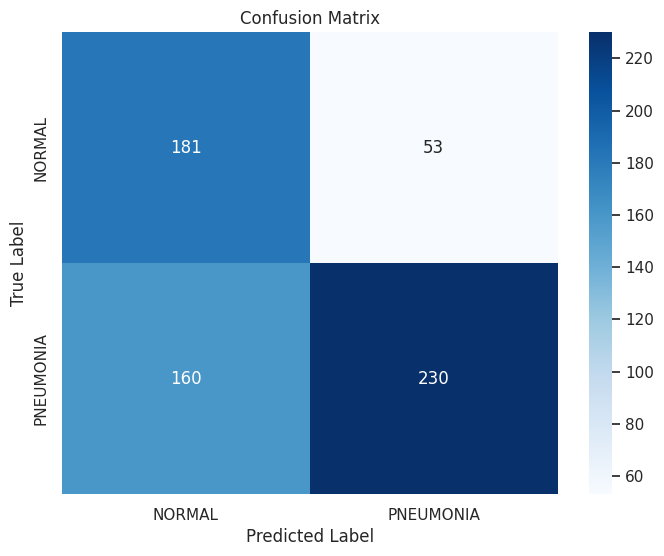

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as chart

print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=['NORMAL','PNEUMONIA'])) # Corrected target_names order

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
chart.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
chart.xlabel('Predicted Label')
chart.ylabel('True Label')
chart.title('Confusion Matrix')
chart.show()